2023-08-28 02:53:28.001664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-28 02:53:28.001712: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


XL [-200. -200. -200. -200.]
XU [200. 200. 200. 200.]
g_L [-2.e+19 -2.e+19] [0 0]
Num Iteratin:  0
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [0. 0. 0. 0.]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

The elapsed time is 2.1925392150878906 s
Solution of the primal variables, x
x[0] = -200.00000197994004
x[1] = -200.00000197994004
x[2] = -70.2950997108508
x[3] = -70.2950997107738
status= 0
Objective value
f(x*) = 15.612650108287328
Control action=:   -200.00000197994004 -200.00000197994004
Real model output x :   
Num Iteratin:  1
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Proble

The elapsed time is 24.79449224472046 s
Solution of the primal variables, x
x[0] = -0.8420408877279546
x[1] = -0.8438667548295089
x[2] = -0.8316939374460213
x[3] = -0.8320057828302593
status= 0
Objective value
f(x*) = 2.8153297224827414e-06
Control action=:   -0.8420408877279546 -0.8438667548295089
Real model output x :   
Num Iteratin:  17
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [-0.83169394 -0.83200578 -0.83169394 -0.83200578]
The elapsed time is 24.65758967399597 s
Solution of the primal variables, x
x[0] = -0.7966184108755088
x[1] = -0.7977947753630643
x[2] = -0.801462376879716
x[3] = -0.8014866621665485
status= 0
Objective value
f(x*) = 2.558150577656968e-06
Control action=:   -0.7966184108755088 -0.7977947753630643
Real model output x :   
Num Iteratin:  18
[PyIPOPT] Ipopt will use Hessian approximation.

[PyIPOPT] Problem created
Going to call solve
x0 = [-0.80146238 -0.80148666 -0.80146238 -0.80148666]
The elapsed time

/tmp/ipykernel_29193/2335671884.py:798: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


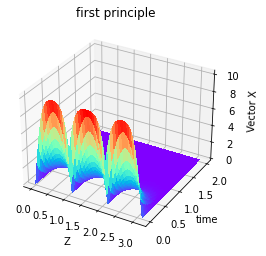

In [1]:
#!/usr/bin/python


from __future__ import print_function
import pandas
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from scipy.optimize import NonlinearConstraint, LinearConstraint
from scipy.optimize import BFGS, minimize, Bounds, SR1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
import numpy
from keras.models import model_from_json, load_model
from pathlib import Path
import os.path
import time
import os
import math
import pyipopt
from numpy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
#####Simulation time step
dim_x = 45
dim_t = 100
tsteps = 5

delta=0.1
hc=0.2/dim_t #delta/100
oper_time=0.01

short_factor=int(0.1/delta)
####Initial states
init_value = 10.0

v = np.array([init_value]*(dim_x + 1))
#v = np.array([0.        , 0.06590335, 0.12971408, 0.18919117, 0.24199136,
       # 0.28575967, 0.31826327, 0.33755938, 0.34218097, 0.33131661,
       # 0.30495719, 0.26398132, 0.21015675, 0.14604578, 0.07481896,
       # 0.        , 0.15071257, 0.29566849, 0.42870321, 0.5437511 ,
       # 0.6353443 , 0.69903038, 0.73167937, 0.73167937, 0.69903038,
       # 0.6353443 , 0.5437511 , 0.42870321, 0.29566849, 0.15071257,
       # 0.        , 0.07481896, 0.14604578, 0.21015675, 0.26398132,
       # 0.30495719, 0.33131661, 0.34218097, 0.33755938, 0.31826327,
       # 0.28575967, 0.24199136, 0.18919117, 0.12971408, 0.06590335,
       # 0.        ])

# xi_record = []
# for i in range(dim_x):
# 	xi_record.append(v[i])
xi_record = v
u1_record=[]
u2_record=[]
rfd_record = []
time_record=[]


#a=1060
#b=22
#d=0.52

x_record=[0,0] ## for u

#w1_std=2.5
#w2_std=70

ROOT_FOLDER=os.getcwd()
#### CONSTANTS ####
NUM_MPC_ITERATION=20*short_factor   #10000000000

OUTPUT_NO=0
TOTAL_MODELS=12 # used to be 8
NUM_SUBMODELS=1 # when you use ensemble learning 
NUM_OUTPUTS=dim_x+1
NUM_INPUTS=(dim_x+3)   # FOR NN, initial conditions are taken as NN inputs as well, therefore we have four: CA, T, CA0, Q
HORIZON=2

NUM_IN_SEQUENCE=(dim_t + 1)   # Depend on how many hc you want to use. Must be consistent the NN model development.
PREDICTION_STORE=0

deviation=0
NUM_MPC_INPUTS=2*HORIZON
NUM_MPC_CONSTRAINTS=HORIZON
realtime_data=None
#setpoint=[0, 0]
#setpoint = np.load(file = 'setpoint_ff.npy')
setpoint = np.array([0.0]*(dim_x + 1))

uu1=[-199.99993841528183, -174.30717480168727, -124.79545882266673, -107.20570699891789, -96.19065031218149, -110.8519060012556]

uu2=[-199.99975496379008, -199.99938430307685, -199.99234591096402, -199.96569664133102, -199.9296335273948, -190.4848958685224]



def my_ens_prediction(num_horizon,my_rawdata,my_inputs):
    xx = []
    nn_inputs = []
    ensemble_output = numpy.zeros((num_horizon,NUM_OUTPUTS,10))
    
    ensemble_output = ensemble_output.reshape(num_horizon,10,NUM_OUTPUTS)  # (horizon = 2, NUM_IN_SEQUENCE = 20 (/100), NUM_OUTPUTS=2)
    predict_output = []
    x_test2 = my_rawdata[0:(dim_x + 1)].astype(float) # CA(tk) and T(tk)
    #x_test2= (x_test2-state_mean)/state_std
    #print('XXXXX', x_test2.shape)
    #print('XXXXX', x_test2)
    xx2 = []
    for i in range(dim_x + 1):
    	xx2.append(x_test2)
    x_test2 = xx2
    x_test2 = np.array(x_test2)
    #x_test2.reshape(-1,30,1)
    #print('XXXXX', x_test2.shape)
    #x_test2 = [x for y in x_test2 for x in y]
    #x_test2 = np.array(x_test2)           # my_rawdata is normal value; needs to normalize before feeding into NN
    #x_test2 = numpy.array(encoder.predict(x_test2)[0])
    #print('XXXXX', x_test2.shape)
    #print('XXXXX', x_test2)



    predict_output_normal=[[0 for i in range(NUM_OUTPUTS)] for j in range(NUM_IN_SEQUENCE)]

    for i_model in range(num_horizon):    
        # i_model=0
        # my_inputs=[640]*4    
        
        ## my_inputs is u 
        #print('input mean ', input_mean)
        #print('input std', input_std)
        #my_inputs_normalized = (my_inputs[2*i_model:2*(i_model+1)] - input_mean) / input_std    # my_inputs is also normal value; needs to normalize before feeding into NN
        my_inputs_normalized = my_inputs[2*i_model:2*(i_model+1)]
        sum=[[0 for i in range(NUM_OUTPUTS)] for j in range(NUM_IN_SEQUENCE)]  # sum up all ensemble models
        #print('IIIII', my_inputs_normalized)

        #xx = numpy.concatenate((x_test2,  my_inputs_normalized), axis=None).reshape((1, NUM_INPUTS))  # xx is the NN input (CA, T, CA0, Q)
        xx = np.hstack((x_test2.flatten(),  my_inputs_normalized))
        #print('XXXXXXXXXX shape',xx.shape)
        #xx = numpy.tile(xx, (NUM_IN_SEQUENCE, 1))  # duplicate #NUM_IN_SEQUENCE times  
        #xx = numpy.tile(xx, NUM_IN_SEQUENCE)
        #print('XXXXXXXXXX shape',xx)
        dt = 0.2/dim_t
        dx = np.pi/dim_x
        a = dt/dx**2
        T_array = np.linspace(0, delta, dim_t + 1)
        #print(T_array)
        X_array = np.linspace(0,np.pi,dim_x + 1)
        initial_st = xx[0:dim_x + 1]
        u1 = xx[-2]###
        u2 = xx[-1] ###
        res = diff_schemes(dt,dx,a,X_array,T_array,u1,u2,initial_st)
        ic = res.init_condition()
        rfd1 = res.forward_diff_scheme()

        #nn_inputs = xx.reshape(-1, NUM_IN_SEQUENCE, NUM_INPUTS) 


        #for j_submodel in range (NUM_SUBMODELS):  # ENSEMBLE MODEL
            # j_submodel=0
            #predict_output = numpy.array(model[j_submodel].predict(nn_inputs))
            #predict_output = predict_output.reshape(NUM_IN_SEQUENCE, NUM_OUTPUTS)
            # print ("submodel id:", j_submodel)
            # print ("submodel:", predict_output)
            #if not math.isnan(predict_output[0,0]):
            #sum=sum+predict_output
             
        # MODEL AVERAGING (ENSEMBLE LEARNING)
        #predict_output=sum/NUM_SUBMODELS
        #print (predict_output.shape)
        predict_output=rfd1


        x_test2=predict_output[-1,0:dim_x + 1]

        #########  if delta=0.005##########
        #x_test2=predict_output[int(NUM_IN_SEQUENCE/2-1),0:2]
        #x_test2 = predict_output[int(NUM_IN_SEQUENCE/short_factor-1), 0:2] ## No need in general (short_factor) is only used when, e,g., your NN predict 1 hr, but you want to recursively predict 0.05hr




        # The following two lines are done if output statistical info is different from input 


        # dataset: input dataset (CA(tk), T(tk), CA0, Q), output dataset (CA(t), T(t))  

        #x_test2=x_test2 * output_std + output_mean   # output normal value
        #x_test2 = (x_test2 - state_mean) / state_std   # re-normalize using input statistical info.


        # RESCALING BY THE CORRESPONDING STANDARD DEVIATION & THE MEAN OF THE OUTPUT STATISTICS OF THE EXITING SURFACE
        #predict_output_normal = predict_output * output_std + output_mean
        predict_output_normal = predict_output


        #predict_output_normal=predict_output_normal*[y2_std, y1_std]+[y2_mean, y1_mean]
        #print("predict_output_normal=",predict_output_normal)
        #print("ensemble_output=",ensemble_output.shape)


        ensemble_output[i_model,:,:]=predict_output_normal

    return ensemble_output    



#################################################
################## MPC PROGRAM ##################
#################################################
### DEFINE THE UPPER BOUND AND LOWER BOUND OF THE MANIPULATED INPUTS ###

def eval_f(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    offset=0
    global PREDICTION_STORE
    #### CALCULATE OUTLET CONC ###########
    df_ensemble_output = my_ens_prediction(num_horizon=int(NUM_MPC_INPUTS/2),my_rawdata=realtime_data,my_inputs=x)
    # LAST SUBENSEMBLE, LAST TIME STEP, FIRST VARIABLE
    # factor=realtime_data[1] **2 *500 /(realtime_data[0] **2 *50)
    # factor2=realtime_data[1] **2 *500 /(3.5 **2 *100)
    #### account for all intermediate steps ####
    for j in range (HORIZON):
        est_outlet_product = df_ensemble_output[j, :, 0:(dim_x + 1)]
        for i in range (10):#(int(NUM_IN_SEQUENCE/short_factor)):  #NUM_IN_SEQUENCE/2
            for k in range(dim_x):
           
             #print('SSSSSS', setpoint)
             #print('EEEEEE', est_outlet_product[i])
                 offset = offset + (setpoint[0] - (est_outlet_product[i, k])) ** 2.0*1e-1
        offset=offset+x[2*j] **2*1e-4 + 1* x[2*j+1] **2*1e-4
        #offset=offset+(x[1]-x_record[1])**2 *factor2/10+(x[0]-x_record[0])**2 *factor2/1e11
        #print('SSSSSS', setpoint)
        #print('EEEEEE', est_outlet_product)



 
    return offset/100

def eval_grad_f(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1 # we just have a small step
    objp=objm=0
    grad_f = [0]*NUM_MPC_INPUTS
    xpstep = [0]*NUM_MPC_INPUTS
    xmstep = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
        xpstep[i_mpc_input]  = xpstep[i_mpc_input]+step 
        xmstep[i_mpc_input] = xmstep[i_mpc_input]-step
        #print ("step: ", step)
        #print ("xp:  ",xpstep)
        #print ("xm:  ",xmstep)
        #print ("i_mpc_input:  ",i_mpc_input)
        # Evaluate the objective function at xpstep and xmstep
        objp=eval_f(xpstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed +step
        objm=eval_f(xmstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed -step
        #print ("obj ", objp, "   objm   ", objm)
        grad_f[i_mpc_input] = (objp - objm) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable x[i]
    #print("Gradient: ", grad_f)
    return array(grad_f)

def eval_g(x):
    assert len(x) == int(NUM_MPC_INPUTS)
    #### CALCULATE FLUID TEMPERATURE ALONG THE FIRST THREE SURFACES ###########
    #df_ensemble_output = my_ens_prediction(num_horizon=NUM_CONSTRAINT_MODELS,my_rawdata=realtime_data,my_inputs=x)
    #CAd2=realtime_data[1]
    #Td2=realtime_data[0]
    ##pred_states=df_ensemble_output[-1, -1, 0:2]
    #CAd2=df_ensemble_output[-1, -1, 1]
    #Td2
    g=array([-5.0]*NUM_MPC_CONSTRAINTS)
    #print ("gggg", g)

    # if ((a*CAd2**2+d*Td2**2+2*b*CAd2*Td2-2)> 0):
        
    #     df_ensemble_output3 = my_ens_prediction(num_horizon=1,my_rawdata=realtime_data, my_inputs=x)
    #     est_outlet = df_ensemble_output3[-1, -1, 0:2].reshape(1,2)
    #     dot_V1=(2*a * CAd2 + 2*b * Td2)*((est_outlet[0][1])-CAd2)/(0.01)+\
    #             (2*d*Td2 + 2*b * CAd2)*((est_outlet[0][0])-Td2)/(0.01)
    #     #print ("dot V", dot_V1)

    #     vv=a*CAd2**2+d*Td2**2+2*b*CAd2*Td2
    #     g[0]=dot_V1+15*abs(vv/100)   # To simplify calculation, we use the constraint, dot_V(x,u) < -15 V to make sure dot_V is neg. 

    #     #g[0]=dot_V-dot_Vt#+1#e-2 

    # else:
    #     df_ensemble_output2 = my_ens_prediction(num_horizon=int(NUM_MPC_INPUTS / 2), my_rawdata=realtime_data,
    #                                            my_inputs=x)
    #     # LAST SUBENSEMBLE, LAST TIME STEP, FIRST VARIABLE

        
    #     #####  only account for the last point #####
    #     for j in range(int(NUM_MPC_INPUTS / 2)):
    #         est_outlet_product2 = df_ensemble_output2[j, int(NUM_IN_SEQUENCE/short_factor-1), 0:2]  #int(NUM_IN_SEQUENCE/2-1)
    #         # for i in range(NUM_IN_SEQUENCE):
    #         g[j]= d * (est_outlet_product2[0]) ** 2+ 2 * b * (est_outlet_product2[0])*(est_outlet_product2[1]) + \
    #               a*(est_outlet_product2[1]) ** 2 -2
    #         # this corresponds to the constraint: V(x,u) < 2 (\rho_min or \rho_nn in different papers)



    return  g

nnzj = NUM_MPC_CONSTRAINTS*NUM_MPC_INPUTS


def eval_jac_g(x, flag):
    #print ("in eval_jac_g_0")
    if flag:
        list_x = []
        list_y=[]
        for i in range(int(NUM_MPC_INPUTS / 2)):
            list_x = list_x + [i] * NUM_MPC_INPUTS
            list_y = list_y +list(range(0, int(NUM_MPC_INPUTS)))
        #list_x=[0]*int(NUM_MPC_INPUTS)+[1]*int(NUM_MPC_INPUTS)
        #list_y=list(range(0, int(NUM_MPC_INPUTS)))+list(range(0, int(NUM_MPC_INPUTS)))
        #print ("list_x:", list_x)
        #print("list_y:", list_y)
        return (array(list_x),
                array(list_y))

        #return (array([0, 0]),
        #        array([0, 1]))
        #print ("in eval_jac_g_1")
    else:
        assert len(x) == int(NUM_MPC_INPUTS)
        step = 1 # we just have a small step
        gp=gm=numpy.zeros(NUM_MPC_CONSTRAINTS)
        xpstep=xmstep=numpy.zeros(NUM_MPC_INPUTS)
        jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
        #print ("shape:", jac_g)
        for i_mpc_input in range(NUM_MPC_INPUTS):
            xpstep=x.copy()
            xmstep=x.copy()
            # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
            xpstep[i_mpc_input] += step 
            xmstep[i_mpc_input] -= step
            gp=eval_g(xpstep)
            gm=eval_g(xmstep)
            for num_constraint in range(NUM_MPC_CONSTRAINTS):
                jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)
            #print ("in eval_jac_g_2:")
        return array(jac_g)

def apply_new(x):
    return True
def print_variable(variable_name, value):
    for i in range(len(value)):
        print("{} {}".format(variable_name + "["+str(i)+"] =", value[i]))


nnzh = NUM_MPC_INPUTS**2
# def eval_h(x, lagrange, obj_factor, flag, user_data = None):
#     if flag:
#         hrow = [0, 1, 1, 2, 2, 2, 3, 3, 3, 3]
#         hcol = [0, 0, 1, 0, 1, 2, 0, 1, 2, 3]
#         return (array(hcol), array(hrow))
#     else:
#         values = zeros((10), float_)
#         values[0] = obj_factor * (2*x[3])
#         values[1] = obj_factor * (x[3])
#         values[2] = 0
#         values[3] = obj_factor * (x[3])
#         values[4] = 0
#         values[5] = 0
#         values[6] = obj_factor * (2*x[0] + x[1] + x[2])
#         values[7] = obj_factor * (x[0])
#         values[8] = obj_factor * (x[0])
#         values[9] = 0
#         values[1] += lagrange[0] * (x[2] * x[3])

#         values[3] += lagrange[0] * (x[1] * x[3])
#         values[4] += lagrange[0] * (x[0] * x[3])

#         values[6] += lagrange[0] * (x[1] * x[2])
#         values[7] += lagrange[0] * (x[0] * x[2])
#         values[8] += lagrange[0] * (x[0] * x[1])
#         values[0] += lagrange[1] * 2
#         values[2] += lagrange[1] * 2
#         values[5] += lagrange[1] * 2
#         values[9] += lagrange[1] * 2
#         return values

#####################################################################
##### PRE-PROCESSING (THE FOLLOWING COMMANDS ARE EXECUTED ONCE) #####
#####################################################################
#### LOAD MEAN AND STD FILES###########
#### READ MEANS & STD FROM THE FILE #####
# dataframe_summary= pandas.read_csv("train.summary.csv",   skiprows=1, header=None)
# train_summary = dataframe_summary.values
# train_summary=train_summary[0:,1:].astype(float)
# print (train_summary)

# x1_mean=train_summary[1,0]
# x1_std=train_summary[1,1]
# x2_mean=train_summary[0,0]
# x2_std=train_summary[0,1]
# u1_mean=train_summary[3,0]
# u1_std=train_summary[3,1]
# u2_mean=train_summary[2,0]
# u2_std=train_summary[2,1]
# y1_mean=train_summary[5,0]
# y1_std=train_summary[5,1]
# y2_mean=train_summary[4,0]
# y2_std=train_summary[4,1]
#x1_mean=-0.032   # CA
#x1_std=0.821835
#x2_mean=1.08767  # T
#x2_std= 38.2311
#u1_mean=0    # CA0
#u1_std=2.233997
#u2_mean=0     # Q
#u2_std=319142.4091
#y1_mean=-0.02642
#y1_std=0.813491
#y2_mean=1.08767
#y2_std=38.23118
#Here!!!!

# from sklearn.preprocessing import StandardScaler

# state_summary = np.load(file = 'new_output_ff.npy')
# state_summary = [x for y in state_summary for x in y]
# state_summary = np.array(state_summary)
# scaler_st = StandardScaler(copy=True, with_mean=True, with_std=True)
# st_norm = scaler_st.fit(state_summary)
# state_mean=scaler_st.mean_
# state_std=np.sqrt(scaler_st.var_)
# state_std[0] = 1.0
# state_std[-1] = 1.0
# #print('StateSTD',state_std)

# #state_mean=numpy.array([x2_mean, x1_mean])
# #state_std=numpy.array([x2_std, x1_std])

# input_summary = np.load(file = 'uu_f_1.npy')
# #input_summary = input_summary[:,-2:]
# scaler_in = StandardScaler(copy=True, with_mean=True, with_std=True)
# in_norm = scaler_in.fit(input_summary)
# input_mean=scaler_in.mean_
# input_std=np.sqrt(scaler_in.var_)

#input_mean=numpy.array([u2_mean, u1_mean])
#input_std=numpy.array([u2_std, u1_std])
#output_mean=numpy.array([y2_mean, y1_mean])
#output_std=numpy.array([y2_std, y1_std])


model=[1]*(NUM_SUBMODELS)
#encoder =  [1]*(NUM_SUBMODELS)
#print(model)
#### LOAD NEURAL NETWORK MODELS ####

# for j_submodel in range (TOTAL_MODELS):
#     #print ("NOW IT IS :", j_submodel)
#     model_path = Path("MODEL/model" + str(j_submodel + 1)+ ".h5")
#     #filename=Path("model" + str(j_submodel + 1))
#     #print(model_path)
#     #if (os.path.isfile(model_path)==True)
#     if (model_path.exists()):
#         model[0] = load_model(model_path)
#         print ("NOW IT IS :", j_submodel+1)
#         OUTPUT_NO=j_submodel+1




# model[0]=load_model("RNN_ff.h5")
# encoder=load_model("encoder_ff.h5")


class diff_schemes:
    
    def __init__(self,dt,dx,r,x,t,u1,u2,initial_st):
        self.dt = dt
        self.dx = dx
        self.r = r # alpha*tol/h^2
        self.x = x
        self.t = t
        self.u1 = u1
        self.u2 = u2
        self.initial_st = initial_st
        
    def make_figure(self,matx,title_msg):
        fig = plt.figure()
        ax = fig.gca(projection = '3d')
        x, y = np.meshgrid(self.x, self.t)
        z = matx
        ax.plot_surface(x, y, z, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        plt.title(title_msg)
        plt.show()
        
    def init_condition(self):
        return self.initial_st
    
    def forward_diff_scheme(self):
        matx_record = []
        matx = np.zeros([len(self.t),len(self.x)])
        matx[0,:] = self.initial_st
        matx[:,0] = 0
        matx[:,-1] = 0
        for ii in range(1, len(self.t)):
            for jj in range(1,len(self.x)-1):
                if self.x[jj] == np.pi/3:
                    dd1 = 5
                elif self.x[jj] == 2*np.pi/3:
                    dd2 = 5
                else:
                    dd1 = 0.0
                    dd2 = 0.0
                matx[ii,jj] = self.r*(matx[ii-1,jj-1]-2*matx[ii-1,jj]+matx[ii-1,jj+1]) + self.dt*(50*(np.exp(-4/(1+matx[ii-1,jj]))-np.exp(-4))) - self.dt*2*matx[ii-1,jj] + self.dt*2*((dd1/2)*self.u1+(dd2/2)*self.u2) + matx[ii-1,jj]
                if matx[ii,jj]<0:
                	matx[ii,jj] = 0
            if ii%10 == 0:
                matx_record.append(matx[ii])
                #print(range(1, len(self.t)))
                #print('i: ',i)
                #print('\n j: ',j)
                #print('\n ',matx[i,j])
        #print(matx)
        matx_record = np.array(matx_record)
        return matx_record
    
####################################################################
##### SOLVING THE MPC PROGRAM TO FIND THE OPTIMIZED MPC INPUTS #####
####################################################################
##########  KEEP RUNNING MPC ###############

dir_name = os.getcwd()
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".txt"):
        os.remove(os.path.join(dir_name, item))


nvar = NUM_MPC_INPUTS
x_lower=[0]* nvar
x_upper=[0]* nvar
for i in range(int(NUM_MPC_INPUTS/2)):
    x_lower[2*i]=-200.0
    x_lower[2 * i+1] = -200.0
    x_upper[2 * i] = 200.0
    x_upper[2 * i + 1] = 200.0
x_L = array(x_lower) #array([-5e5, -3.5])
x_U = array(x_upper) #array([5e5, 3.5])
print('XL',x_L)
print('XU', x_U)
### DEFINE THE UPPER BOUND AND LOWER BOUND OF THE CONSTRAINT ###
ncon = NUM_MPC_CONSTRAINTS
g_L = array([-2e19]*HORIZON)
g_U = array([0]*HORIZON)

print ("g_L", g_L, g_U)



for main_iteration in range(NUM_MPC_ITERATION):
    print ("Num Iteratin: ", main_iteration)
    #check_file = Path("indicator.out")
    #while not os.path.exists(check_file):
    #    time.sleep(1)
    #os.remove(check_file)  

    #if main_iteration >0:
     #   deviation=deviation-PREDICTION_STORE
     #   setpoint = SETPOINT_TRUE-deviation
    #else:
    #    setpoint = SETPOINT_TRUE 
    #print ("setpoint: ", setpoint)
    #print ("deviation: ", deviation)
    #print ("PREDICTION_STORE: ",PREDICTION_STORE)
    

    rawdata=v
    #### NORMALIZE RAW DATA ####
    #rawdata=(rawdata-state_mean)/state_std
    # print ("normalized data:  ", rawdata)
    realtime_data=rawdata

    start = time.time()
    nlp = pyipopt.create(nvar, x_L, x_U, ncon, g_L, g_U, nnzj, nnzh, eval_f, eval_grad_f, eval_g, eval_jac_g)
    #x0 = array([3.33, 3.8, 3.8, 6])
    if main_iteration ==0 :
        x0 = array([0.0]*int(NUM_MPC_INPUTS))
        #x0= array ([-5e5, 3.5, -5e5, 3.5])
    else:
        x0=x
        x0[0:-2]=x[2:]
        x0[-2:]=x[-2:]#[0, 0]
        x_record=x

    #print('Here', x0)
        #x0 = array([0.0] * int(NUM_MPC_INPUTS))
        #x0=array(x[:-2], 0, 0)
    """
    print x0
    print nvar, ncon, nnzj
    print x_L,  x_U
    print g_L, g_U
    print eval_f(x0)
    print eval_grad_f(x0)
    print eval_g(x0)
    a =  eval_jac_g(x0, True)
    print "a = ", a[1], a[0]
    print eval_jac_g(x0, False)
    print eval_h(x0, pi0, 1.0, False)
    print eval_h(x0, pi0, 1.0, True)
    """

    """ You CAd2 set Ipopt options by calling nlp.num_option, nlp.str_option
    or nlp.int_option. For instance, to set the tolarance by calling

        nlp.num_option('tol', 1e-8)

    For a complete list of Ipopt options, refer to

        http://www.coin-or.org/Ipopt/documentation/node59.html

    Note that Ipopt distinguishs between Int, Num, and Str options, yet sometimes
    does not explicitly tell you which option is which.  If you are not sure about
    the option's type, just try it in PyIpopt.  If you try to set one type of
    option using the wrong function, Pyipopt will remind you of it. """
    nlp.int_option('max_iter', 100) ## ?
    nlp.num_option('tol', 1e-5)
    nlp.int_option('print_level', 2)
    print("Going to call solve")
    print("x0 = {}".format(x0))
    x, zl, zu, constraint_multipliers, obj, status = nlp.solve(x0)



    # import pdb; pdb.set_trace()
    nlp.close()
    end = time.time()
    print("The elapsed time is", end - start, "s")
    time_record.append(end-start)

    print("Solution of the primal variables, x")
    print_variable("x", x)
    print ("status=", status)
    # print("Solution of the bound multipliers, z_L and z_U")
    # print_variable("z_L", zl)
    # print_variable("z_U", zu)

    # print("Solution of the constraint multipliers, lambda")
    # print_variable("lambda", constraint_multipliers)

    print("Objective value")
    print("f(x*) = {}".format(obj))
    print ("Control action=:  ", x[0], x[1])
    #REAL_CONTROL_ACTION=x*
    #print ("REAL DATA:", REAL_CONTROL_ACTION)
    #numpy.savetxt("input_to_fluent.out",   REAL_CONTROL_ACTION, fmt="%f",  delimiter=" ")

    # w is the disturbance
    #w1 =numpy.random.normal(0, w1_std, 1)
    #w2 =numpy.random.normal(0, w2_std, 1)
    #if w1>w1_std:
        #w1=w1_std
    #if w1<-w1_std:
        #w1=-w1_std
    #if w2>w2_std:
        #w2=w2_std
    #if w2>w2_std:
        #w2=w2_std
    #print (numpy.asscalar(w1))
    #print (numpy.asscalar(w2))
    #for kk in range (int(delta/hc)):
    dt = 0.2/dim_t
    dx = np.pi/dim_x
    a = dt/dx**2
    T_array = np.linspace(0, delta, int(delta/hc+1))
    #print(T_array)
    X_array = np.linspace(0,np.pi,(dim_x + 1))
    initial_st = v
    u1 = x[0]###
    #u1 = uu1[main_iteration]
    u2 = x[1]
    #u2 = uu1[main_iteration] ###
    res = diff_schemes(dt,dx,a,X_array,T_array,u1,u2,initial_st)
    ic = res.init_condition()
    rfd = res.forward_diff_scheme()
    #print(rfd.shape)
    #res.make_figure(rfd, 'x surface')



        #x1 = x1_new
        #x2 = x2_new

        #if (kk%5==1):  #  NN takes points every 5 integration time steps
    #for i in range(dim_x):
    	#xi_record[i].append(rfd[:,i])
    xi_record = np.vstack((xi_record, rfd))
    u1_record.append(x[0])
    u2_record.append(x[1])

    rfd_record.append(rfd)

    for i in range(dim_x):
    	v[i] = rfd[-1,i]
    

        #print ("First principle intermediate steps x1, x2:  ", x1, x2)
        #print("First principle intermediate derivatives x1, x2:  ", x1_derivate, x2_derivate)

    #x1=x1-CAs
    #x2=x2-Ts
    #print('Real model output x1 x2 in deviation form:   ', x1, x2)
    print('Real model output x :   ')
    #x1=(x1 -y1_mean)/y1_std
    #x2 = (x2 - y2_mean) / y2_std
    # x1_record.append(x1)
    # x2_record.append(x2)
    # u1_record.append(x[1])
    # u2_record.append(x[0])
# for i in range(dim_x):
# 	j = i
# 	j = str(j)
# 	print (j + 'record is \n')
# 	print(np.array(xi_record[i])
numpy.set_printoptions(threshold=50000)

#print(np.array(xi_record).reshape(-1,int(delta/hc+2),dim_x + 1))

print(np.array(xi_record))
print ("u1_record: ",u1_record)
print ("u2_record: ",u2_record)
print("time_record: ", time_record)
print("total time: ", sum(time_record), "s")
print("average time for each iteration:", sum(time_record)/len(time_record), 's')


# filename1=Path("OUTPUT/model" + str(OUTPUT_NO)+"-x1.txt")
# filename2=Path("OUTPUT/model" + str(OUTPUT_NO)+"-x2.txt")
# filename3=Path("OUTPUT/model" + str(OUTPUT_NO)+"-u1.txt")
# filename4=Path("OUTPUT/model" + str(OUTPUT_NO)+"-u2.txt")

#
#record = pd.DataFrame(xi_record)
#record.to_csv('first_principle_mpc.csv')

# numpy.savetxt("x1.txt",   x1_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x2.txt",   x2_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x3.txt",   x3_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x4.txt",   x4_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x5.txt",   x5_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x6.txt",   x6_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x7.txt",   x7_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x8.txt",   x8_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x9.txt",   x9_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x10.txt",   x10_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x11.txt",   x11_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x12.txt",   x12_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x13.txt",   x13_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x14.txt",   x14_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x15.txt",   x15_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x16.txt",   x16_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x17.txt",   x17_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x18.txt",   x18_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x19.txt",   x19_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x20.txt",   x20_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x21.txt",   x21_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x22.txt",   x22_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x23.txt",   x23_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x24.txt",   x24_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x25.txt",   x25_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x26.txt",   x26_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x27.txt",   x27_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x28.txt",   x28_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x29.txt",   x29_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x30.txt",   x30_record, fmt="%f",  delimiter=" ")
# numpy.savetxt("x31.txt",   x31_record, fmt="%f",  delimiter=" ")


numpy.savetxt("u1.txt",   u1_record, fmt="%f",  delimiter=" ")
numpy.savetxt("u2.txt",   u2_record, fmt="%f",  delimiter=" ")
numpy.savetxt("time.txt",   time_record, fmt="%f",  delimiter=" ")

rfd_record = [x for y in rfd_record for x in y]
rfd_record = np.array(rfd_record)
#print(rfd_record.shape)
#res.make_figure(rfd_record, 'x0 = 7.5')
fig = plt.figure()
ax = fig.gca(projection = '3d')
x_ax = np.array(np.linspace(0, np.pi, (dim_x + 1)))
#print('XXXXXXX',x_ax.shape)
y_ax = np.array(np.linspace(0, delta*NUM_MPC_ITERATION, int(5)*NUM_MPC_ITERATION))
print('YYYYYYY', y_ax.shape)
x, y = np.meshgrid(x_ax, y_ax)
#print()
z = rfd_record
print('ZZZZZZZ', z.shape)
ax.plot_surface(x, y, z, cmap = cm.rainbow, linewidth = 0, antialiased = False)
ax.set_xlabel('Z')
ax.set_ylabel('time')
ax.set_zlabel('Vector X')
plt.title('first principle')
plt.show()

# rfd = pd.DataFrame(rfd)
# rfd_record.to_csv('first_principle_mpc.csv')
# np.save(file = 'first_principle_x_ax.npy', arr = x_ax)
# np.save(file = 'first_principle_t_ax.npy', arr = y_ax)
